# Whole-Genome Sequencing 101

This notebook goes through the main step of a whole genome sequencing (WGS) project. It presents:

1. [**DNA Sequencing**](#part1) - obtain *reads* from DNA fragments.
2. [**Genome Assembly**](#part2) - put together a *genome* from reads.
    1. [**De Novo Assembly**](#part21) - assemble the genome from scratch
    2. [**Reference-Based Assembly**](#part22) - assemble the genome by comparing it against a reference genome
3. [**Genome Annotation**](#part3) - document the *functions* of the genome.

**Remember**, this notebook is not a complete WGS tutorial! It only presents the key steps of WGS to
demonstrate their algorithmic complexity. A real bioinformatics pipeline typically does not rely
purely on a Python script but rather executes standalone programs. To learn how to do full WGS
pipelines, please refer to:

- https://pmc.ncbi.nlm.nih.gov/articles/PMC10646344/ for *de novo* WGS (i. e. use that when
  studying an organism or strain with no reference genome)
- https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-023-01495-x for *reference-based*
  WSG (i.e. use that when you have a reference genome for your organism / strain)

In [17]:
# Run this line to ensure that your environment is properly configured.
from random import choice, randint, shuffle
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw

<a id='part1'></a>

## 1. DNA Sequencing

DNA sequencing consists in readings DNA fragments to obtain *reads*, which are sequences of letters
that indicate the base pairs that make up the fragments. There are three *generations* of DNA
sequencing technologies:

| Generation       | Time Frame      | Max Read Length    | Other Names                                | Drawback |
| ---------------- | --------------- | ------------------ | ------------------------------------------ | -------- |
| First (Sanger)   | 1977 - present  | 800 to 1000        | Sanger sequencing  | Slow, expensive |
| Second           | Mid 2000s - present | 50 to 300      | Next-generation sequencing (NGS), Massive parallel sequencing | Reads are short |
| Third            | Late 2000s - present | 100 000       | Long-read sequencing | Higher error rate |

DNA sequencing devices and processing software produce **sequencing files**. FASTQ is a format for
such files. For instance, the following cell is taken from the project described at
https://pmc.ncbi.nlm.nih.gov/articles/PMC9299564/. You can download the sequencing file from the
sequence read archive at https://www.ncbi.nlm.nih.gov/sra?term=SRR10256704.

```
@SRR10256704.1 1 length=137
ACGCGTGATCAGCAAAAGCAGGTCAAATATATTCAATATGGAGAGAATAAAAGAGCTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATCATCAAAAAAT
+SRR10256704.1 1 length=137
?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????
```

The fourth line (`???...`) indicates the **Phred quality score** of the corresponding nucleotides.
The character `?` corresponds to a score of 30, which means that each nucleotide has a probability
of around 0.001 to be incorrectly sequenced. So the quality is pretty good! You can read more about
the quality scores at  https://en.wikipedia.org/wiki/Phred_quality_score.

## What Program to Use

- FastQC (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to visualize quality.
- Trimmomatic (http://www.usadellab.org/cms/?page=trimmomatic) to trim low-quality extremities.
- Trim Galore (https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/) another trimmer.

## How to Obtain Sequences

- To **sequence** DNA, each sequencing device manufacturer releases their own software to process
  the data produced by the devices into sequencing files.
- To **download** DNA sequences that have already been sequenced, you can use:
  - The SRA Toolkit (https://github.com/ncbi/sra-tools/wiki) for sequences hosted by the NCBI (you
    can also visit https://www.ncbi.nlm.nih.gov/sra to download sequences from a browser)
  - The European Nucleotide Archive (https://www.ebi.ac.uk/ena/browser/home), another DNA data bank
    from the EMBL.
  - The DNA DataBank of Japan (DDBJ, https://www.ddbj.nig.ac.jp/index-e.html), another DNA data bank

Most journals require DNA sequences used for a research paper to be deposited in a DNA data bank,
so you can find a lot of sequences on the NCBI/EMBL/DDBJ portals!

## 2. Genome Assembly

<a id='part2'></a>

DNA sequencing technologies only sequence relatively short reads (maximum 100,000 with 3rd gen).
Human chromosomes are much longer than that - from ~47 million base pairs for chromosome 21 to ~249
million base pairs for chromosome 1 (https://www.ncbi.nlm.nih.gov/books/NBK22266/). Ok, the
mitochondrial chromosome is much smaller and *can* get read in one pass of a third generation
sequencer, but that's an exception. We have to split the chromosomes into shorter fragments,
sequence them separately, and assemble them. There are two main approaches to do that:

- De novo (i.e. assemble the fragments from scratch)
- Reference-based (i.e. align the fragments against a reference genome from a similar organism)

<a id='part21'></a>

## 2.1 De Novo Assembly

De novo assembly consists in stitching all reads together by finding their overlaps. Let's try a
naïve approach: each fragment will be compared to all other fragments.

For the sake of demonstration, let's generate a fake DNA sequence and simulate fragment reads:

In [18]:
NUCLEOTIDES = ('A', 'T', 'C', 'G')
SEQUENCE_SIZE = 80
READ_AVERAGE_SIZE = 25
READ_VARIANCE = 12
COVERAGE = 3
MINIMUM_OVERLAP = 4


sequence = "".join([choice(NUCLEOTIDES) for _ in range(SEQUENCE_SIZE)])
print("Simulated DNA sequence:")
print(sequence)
print()


def simulate_reads(sequence: str, variance: int, size: int, verbose: bool = True) -> list[str]:
    reads = []
    if verbose:
        print("Simulating fragment reads:")
    for _ in range(COVERAGE):
        offset = 0
        while offset < len(sequence):
            delta = size + randint(-variance, variance)
            endpoint = offset + delta
            if endpoint > len(sequence):
                endpoint = len(sequence)
            reads.append(sequence[offset:endpoint])
            if verbose:
                print(f"{' ' * offset}{reads[-1]}")
            offset += delta

    if verbose:
        print("Shuffling the reads!")
    shuffle(reads)
    if verbose:
        print(reads)
        print()
    return reads


reads = simulate_reads(sequence, READ_VARIANCE, READ_AVERAGE_SIZE)
print(f"We have {len(reads)} reads for a sequence of {SEQUENCE_SIZE} base pairs.")

Simulated DNA sequence:
TTGACTATCGGTGTTTGGCACAGAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGAGTATTTGCAGTGCATAGGAG

Simulating fragment reads:
TTGACTATCGGTGTTTGGC
                   ACAGAGGGAAGGGTGGTAGCGTAGTGC
                                              CACGATTGGCCTGAGTATTTGCAGTGCATAGGA
                                                                               G
TTGACTATCGGTGTTTGGCACA
                      GAGGGAAGGGTGGTAGCGTAGTGCCA
                                                CGATTGGCCTGAGTAT
                                                                TTGCAGTGCATAGGAG
TTGACTATCGGTGTTTGGCACAGAGGGAAGGG
                                TGGTAGCGTAGTGCCACGATTGGCCTGA
                                                            GTATTTGCAGTGCATAGGAG
Shuffling the reads!
['CACGATTGGCCTGAGTATTTGCAGTGCATAGGA', 'ACAGAGGGAAGGGTGGTAGCGTAGTGC', 'G', 'TTGCAGTGCATAGGAG', 'TTGACTATCGGTGTTTGGCACA', 'TTGACTATCGGTGTTTGGC', 'CGATTGGCCTGAGTAT', 'GAGGGAAGGGTGGTAGCGTAGTGCCA', 'GTATTTGCAGTGCATAGGAG', 'TTGACTA

Let's begin with a naïve approach that performs pairwise comparisons:

In [19]:
def naive_contig(reads: list[str], minimum_overlap: int) -> list[tuple]:
    """Elaborate contigs from the overlaps of the provided reads.

    E.g.:
        read:      AAAACCCC----
        candidate: ----CCCCTTTT
        overlap:       CCCC
        sequence:  AAAACCCCTTTT
    """
    contigs = []
    for i, read in enumerate(reads):
        for candidate in reads[i:]:
            if candidate == read:
                continue  # Do not compare a read to itself!
            overlap_scores = {}
            n_iterations = len(read) + len(candidate)
            for overlap_index in range(1, n_iterations):
                a = len(read) - overlap_index
                b = a + len(candidate)
                X = read[max(a, 0):min(b, len(read))]
                b = overlap_index
                a = overlap_index - len(read)
                Y = candidate[max(a, 0):min(b, len(candidate))]
                score = sum([1 if x == y else -1 for (x, y) in zip(X, Y)])
                overlap_scores[score] = overlap_index
            highest_overlap = max(overlap_scores)
            if highest_overlap >= minimum_overlap:
                offset = overlap_scores[highest_overlap]
                a = f"{'-' * (offset - len(read))}{read}{'-' * (len(candidate) - offset)}"
                b = f"{'-' * (len(read) - offset)}{candidate}{'-' * (offset - len(candidate))}"
                contig = []
                for x, y in zip(a, b):
                    contig.append(x if x != '-' else y)
                contig = "".join(contig)
                if len(contig) > len(read) and len(contig) > len(candidate):
                    contigs.append((read, candidate, offset, len(contig), contig, highest_overlap))
    return contigs


def assemble_with_naive_de_novo(reads: list, verbose: bool = True) -> str:
    current_contigs = reads
    overlap = 6
    for iteration in range(10):
        if verbose:
            print(f"Iteration {iteration}: {current_contigs}")
        initial_count = len(current_contigs)
        tentative = naive_contig(current_contigs, overlap)
        if not tentative:
            break
        contig_data = tentative
        current_contigs = [c[4] for c in contig_data]
        if len(current_contigs) > 32:
            current_contigs = current_contigs[:32]
        current_contigs = list(set(current_contigs))
        if len(current_contigs) in (1, initial_count):
            break
    return sorted(current_contigs, key = lambda x: len(x), reverse = True)[0]

In [20]:
assembly = assemble_with_naive_de_novo(reads)
print(f"Assembled sequence: {assembly}")
print(f"Original sequence:  {sequence}")

Iteration 0: ['CACGATTGGCCTGAGTATTTGCAGTGCATAGGA', 'ACAGAGGGAAGGGTGGTAGCGTAGTGC', 'G', 'TTGCAGTGCATAGGAG', 'TTGACTATCGGTGTTTGGCACA', 'TTGACTATCGGTGTTTGGC', 'CGATTGGCCTGAGTAT', 'GAGGGAAGGGTGGTAGCGTAGTGCCA', 'GTATTTGCAGTGCATAGGAG', 'TTGACTATCGGTGTTTGGCACAGAGGGAAGGG', 'TGGTAGCGTAGTGCCACGATTGGCCTGA']
Iteration 1: ['TTGACTATCGGTGTTTGGCACAGAGGGAAGGGTGGTAGCGTAGTGC', 'TGGTAGCGTAGTGCCACGATTGGCCTGAGTATTTGCAGTGCATAGGA', 'ACAGAGGGAAGGGTGGTAGCGTAGTGCCA', 'ACAGAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGA', 'GAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGA', 'CACGATTGGCCTGAGTATTTGCAGTGCATAGGAG', 'TGGTAGCGTAGTGCCACGATTGGCCTGAGTAT', 'TTGACTATCGGTGTTTGGCACAGAGGGAAGGGTGGTAGCGTAGTGCCA']
Iteration 2: ['GAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGAGTAT', 'GAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGAGTATTTGCAGTGCATAGGA', 'TGGTAGCGTAGTGCCACGATTGGCCTGAGTATTTGCAGTGCATAGGAG', 'TTGACTATCGGTGTTTGGCACAGAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGAGTAT', 'ACAGAGGGAAGGGTGGTAGCGTAGTGCCACGATTGGCCTGAGTATTTGCAGTGCATAGGAG', 'ACAGAGGGAAGGGTGGTAGCGTAGTGCCACGATT

It doesn't *always* converge to the right sequence because the reads are short and may overlap to
the wrong sequence, but this approach works most of the time. How fast is it?

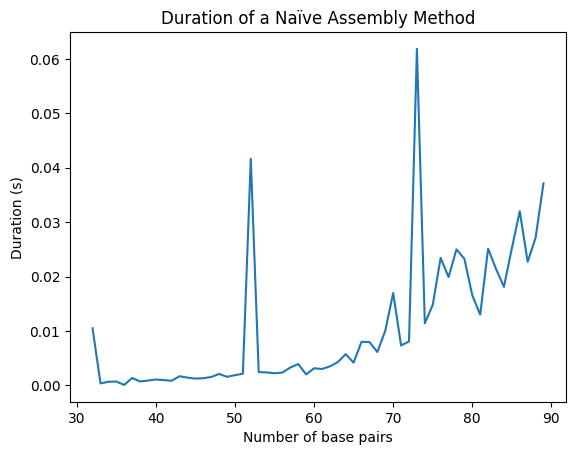

In [21]:
def benchmark_assembly(n: int) -> float:
    N = 10
    total = 0
    for _ in range(N):
        sequence = "".join([choice(NUCLEOTIDES) for _ in range(n)])
        reads = simulate_reads(sequence, READ_VARIANCE, READ_AVERAGE_SIZE, False)
        start = time.time()
        try:
            assemble_with_naive_de_novo(reads, False)
        except:
            print(f"Assembly with N = {n} failed.")
        end = time.time()
        total += end - start
    return total / N


fig, ax = plt.subplots()
N = range(32, 90)
durations = [benchmark_assembly(n) for n in N]
ax.plot(N, durations)
ax.set_title("Duration of a Naïve Assembly Method")
ax.set(xlabel='Number of base pairs', ylabel='Duration (s)')
plt.show()

😱 it runs in O(N<sup>2</sup>) time! That's no surprise, the number of comparisons increases
quadratically with the number of reads. If you wonder why the duration yoyos throughout the tests,
it's because, since the fragments are randomly split, they sometimes happen to be easier to
assemble.

Imagine assembling millions of reads like that! It's way too inefficient, so we'll see two
algorithms that can speed things up: overlap layout consensus (OLC) and De Bruijn graphs (DBG).
Check out https://ocw.mit.edu/courses/7-91j-foundations-of-computational-and-systems-biology-spring-2014/e885f0eb376ea6c2045eb9d8847f106f_MIT7_91JS14_Lecture6.pdf
for a more thorough discussion.

The OLC algorithm comprises three steps:

- Build an **overlap** graph (function `overlap_graph`)
- Reconstruct contigs from the graph - this is called **layout**
- Fix the errors and gaps by comparing the contigs - this is called **consensus** (not shown here)

In [22]:
def prune_unconnected_nodes(G: rx.PyDiGraph) -> None:
    to_remove = []
    for i in G.node_indices():
        if not G.in_edges(i) and not G.out_edges(i):
            to_remove.append(i)
    for r in to_remove:
        G.remove_node(r)


def overlap_graph(reads: list[str], minimum_overlap: int = 3) -> rx.PyDiGraph:
    graph = rx.PyDiGraph()
    nodes = []
    for read in reads:
        nodes.append(graph.add_node(read))
    for n in range(len(graph)):
        N = graph[n]
        for m in range(len(graph)):
            if n == m:
                continue
            M = graph[m]
            best = 0
            for overlap in range(minimum_overlap, len(N) + 1):
                N_suffix = N[-overlap:]
                M_prefix = M[:overlap]
                if N_suffix == M_prefix:
                    best = overlap
            if best:
                graph.add_edge(n, m, -best)
    prune_unconnected_nodes(graph)
    return graph


def find_sources(G: rx.PyDiGraph) -> list[int]:
    sources = []
    for i in G.node_indices():
        if not G.in_edges(i):
            sources.append(i)
    return sources


def find_sinks(G: rx.PyDiGraph) -> list[int]:
    sinks = []
    for i in G.node_indices():
        if not G.out_edges(i):
            sinks.append(i)
    return sinks


def overlap_layout_consensus_contig(reads: list[str], minimum_overlap: int) -> list[tuple]:
    """Elaborate contigs with OLC, which consists in constructing a graph
    directly from reads.
    """
    G = overlap_graph(reads, minimum_overlap)
    sources = find_sources(G)
    sinks = find_sinks(G)
    # Heuristic 1: Pick the longest source.
    source = sources[0]
    for s in sources[1:]:
        if len(G[s]) > len(G[source]):
            source = s
    # Heuristic 2: Find the shortest path through greedy search.
    path = [source]
    overlaps = [0]
    while True:
        try:
            edges = list(G.out_edges(path[-1]))
            edges = sorted(edges, key=lambda x: x[-1])
            edge = sorted(edges, key=lambda x: len(G[x[1]]), reverse=True)[0]
            path.append(edge[1])
            overlaps.append(edge[2])
        except:
            break
        if path[-1] in sinks:
            break
    # Reconstruct the sequence.
    sequence = ""
    for p, o in zip(path, overlaps):
        sequence += G[p][-o:]
    return sequence


def view_graph(G: rx.PyDiGraph, s: int = 12) -> None:
    figure, _ = plt.subplots()
    mpl_draw(
        G,
        with_labels=True,
        labels=str,
        edge_labels=str,
        node_color=[0.75, 0.75, 1],
        node_size=500
    )
    figure.set_figwidth(s)
    figure.set_figheight(s)
    plt.show()

Let's try it out with a simple example:

Original sequence: AAAACCCCTTTT
Overlap graph:


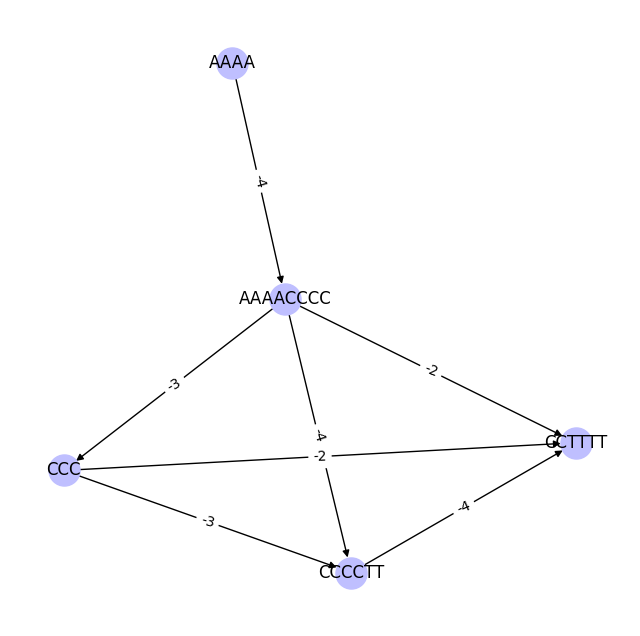

Layout assembly:   AAAACCCCTTTT


In [23]:
print("Original sequence: AAAACCCCTTTT")
reads = ("AAAACCCC", "CCCCTT", "CCTTTT", "AAAA", "CCC")
print("Overlap graph:")
G = overlap_graph(reads, 2)
view_graph(G, 8)
s = overlap_layout_consensus_contig(reads, 2)
print(f"Layout assembly:   {s}")

Ok, let's try with a simulated sequence:

In [24]:
sequence = "".join([choice(NUCLEOTIDES) for _ in range(64)])
print(f"Original sequence: {sequence}")
reads = simulate_reads(sequence, 12, 24)
print("Reconstructing the sequence with OLC:")
s = overlap_layout_consensus_contig(reads, 6)
print(s)

Original sequence: GTGAAGAATCTTTGACCCCGCTTGTATTGATAGCAGCACGTGACATCAAGCGGCCGACTCTCGA
Simulating fragment reads:
GTGAAGAATCTTTGA
               CCCCGCTTGTATTGATAGCAGCACGTGACATCAA
                                                 GCGGCCGACTCTCGA
GTGAAGAATCTTTGACCCCG
                    CTTGTATTGATA
                                GCAGCACGTGACATCAAGCGGCCGACTCTC
                                                              GA
GTGAAGAATCTTTGACCCCGCTTGTATTGATAGC
                                  AGCACGTGACATCAAGCGGCCGACT
                                                           CTCGA
Shuffling the reads!
['AGCACGTGACATCAAGCGGCCGACT', 'CCCCGCTTGTATTGATAGCAGCACGTGACATCAA', 'GCAGCACGTGACATCAAGCGGCCGACTCTC', 'GTGAAGAATCTTTGACCCCGCTTGTATTGATAGC', 'GTGAAGAATCTTTGACCCCG', 'GA', 'CTCGA', 'CTTGTATTGATA', 'GTGAAGAATCTTTGA', 'GCGGCCGACTCTCGA']

Reconstructing the sequence with OLC:
GTGAAGAATCTTTGACCCCGCTTGTATTGATAGCAGCACGTGACATCAAGCGGCCGACTCTCGA


Pretty good! But it doesn't always converge because of the imperfect heuristics. Also, constructing
the graph is time-consuming. The function `overlap_graph` uses pairwise comparisons, so it takes
O(N<sup>2</sup>) time. It's possible to optimize it by binning the reads into categories based on
their prefix and suffix to avoid having to compute some alignments. Also, the layout (i.e.
reconstructing the sequence from the graph) is fast. So OLC is definitely an improvement over the
naïve approach, but it is most applicable to situations in which we have a few long reads, as with
third generation sequencing. In second generation sequencing, the reads are so numerous that
building the overlap graph is expensive.

An algorithm to assemble a very large number of reads is the De Bruijn graph. This method relies on
k-mers, the set of possible substrings that can be elaborated from a string. K-mers act like
specific markers in a sequence, and we will assemble the reads from these markers instead of the
full reads. This makes the computations faster, but it also makes the reconstruction of the original
sequence less accurate.

In [25]:
def get_k_mers(s: str, k: int) -> list[str]:
    """Generate the k-mers of a sequence `s`.

    E.g.:

    >>> get_k_mers("ACGTTCGT", 3)
    ["ACG", "CGT", "GTT", "TTG", "TCG"]
    """
    k_mers = []
    for i in range(len(s) - k + 1):
        k_mers.append(s[i:i + k])
    return list(set(k_mers))


def left_right_k_mers(s: str) -> tuple[str]:
    """Return the left and right (k-1)-mers of the input.

    E.g.:

    >>> left_right_k_mers("ACGT")
    ("ACG", "CGT")
    """
    return s[:-1], s[1:]


def de_bruijn_graph(reads: list[str], k: int) -> list[tuple]:
    """Create a De Bruijn graph."""
    graph = rx.PyDiGraph()
    kmers = []
    for read in reads:
        kmers += get_k_mers(read, k)
    nodes = {}
    for kmer in kmers:
        left_kmer, right_kmer = left_right_k_mers(kmer)
        # Add nodes
        if left_kmer not in nodes:
            nodes[left_kmer] = graph.add_node(left_kmer)
        if right_kmer not in nodes:
            nodes[right_kmer] = graph.add_node(right_kmer)
        # Create edges
        a, b = nodes[left_kmer], nodes[right_kmer]
        if not graph.edge_indices_from_endpoints(a, b) and a != b:
            graph.add_edge(a, b, 1)
    # Connect to another node.
    for node in nodes:
        for base in NUCLEOTIDES:
            target = node[1:] + base
            if target in nodes:
                a, b = nodes[node], nodes[target]
                if a == b:
                    continue
                edge_index = graph.edge_indices_from_endpoints(a, b)
                if not edge_index:
                    graph.add_edge(a, b, 1)
                else:
                    v = graph.get_edge_data(a, b)
                    graph.update_edge(a, b, v + 1)
    return graph


def de_bruijn_contig(reads: list[str], k: int) -> list[tuple]:
    G = de_bruijn_graph(reads, k)
    sources = find_sources(G)
    sinks = find_sinks(G)
    source = sources[0]
    # Find the shortest path through greedy search.
    path = [source]
    while True:
        try:
            edges = list(G.out_edges(path[-1]))
            edges = sorted(edges, key=lambda x: x[-1])
            edge = sorted(edges, key=lambda x: len(G[x[1]]), reverse=True)[0]
            path.append(edge[1])
        except:
            break
        if path[-1] in sinks:
            break
    # Reconstruct the sequence.
    sequence = ""
    for p in path:
        sequence += G[p][0]
    sequence += G[p][1:]
    return sequence

Original sequence: AAAACCCCTTTT
De Bruijn graph:


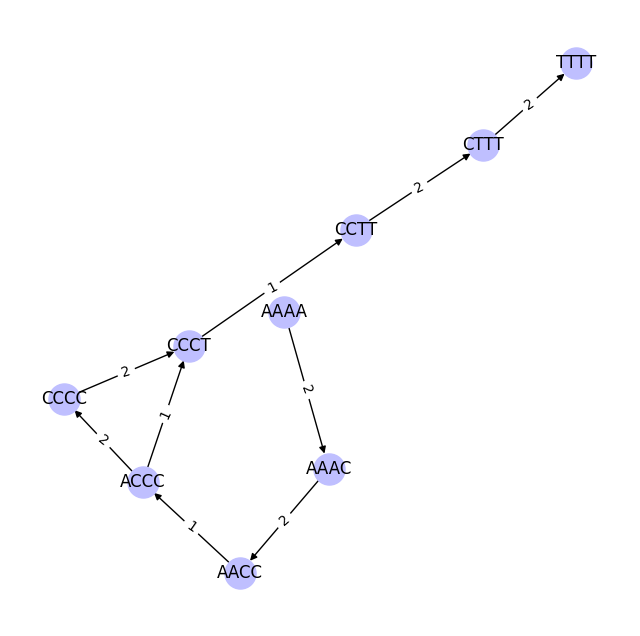

Layout assembly:   AAAACCCTTTT
Original sequence: AAAACCCCTTTT


In [26]:
print("Original sequence: AAAACCCCTTTT")
reads = ("ACCCCT", "CCTTTT", "AAAACC", "ACCCCT")
print("De Bruijn graph:")
G = de_bruijn_graph(reads, 5)
view_graph(G, 8)
reconstruction = de_bruijn_contig(reads, 5)
print(f"Layout assembly:   {reconstruction}")
print(f"Original sequence: AAAACCCCTTTT")

The bulge in the center of the graph is ambiguous. Using the greedy search heuristic, the `CCCC`
node is ignored, but it should actually be included to reconstruct the proper sequence. We can
mitigate this problem by using more advanced heuristics and longer K-mers, but the OLC method 
typically resolves such ambiguities and repetitions better than De Bruijn graphs. Let's try the DBG
with a simulated sequence:

In [27]:
sequence = "".join([choice(NUCLEOTIDES) for _ in range(64)])
print(f"Original sequence: {sequence}")
reads = simulate_reads(sequence, 12, 24)
print("Reconstructing the sequence with DBG:")
s = de_bruijn_contig(reads, 10)
print(s)

Original sequence: CCTTTGTTAGCAGAGTGTCGAGATCCAGCCTCGTGTACGGCTACGGGGACATCTTGCTAGGAAA
Simulating fragment reads:
CCTTTGTTAGCA
            GAGTGTCGAGATCCAGCCTCGTGTACGGC
                                         TACGGGGACATCTTGCTAGGAAA
CCTTTGTTAGCAGAGTGTCGAGATCCAGCCTCG
                                 TGTACGGCTACGGGGACATCTTGCT
                                                          AGGAAA
CCTTTGTTAGCAG
             AGTGTCGAGATCCAGCCTCGTGTACGGCTA
                                           CGGGGACATCTTGCTAGGAAA
Shuffling the reads!
['TGTACGGCTACGGGGACATCTTGCT', 'TACGGGGACATCTTGCTAGGAAA', 'CGGGGACATCTTGCTAGGAAA', 'GAGTGTCGAGATCCAGCCTCGTGTACGGC', 'AGGAAA', 'AGTGTCGAGATCCAGCCTCGTGTACGGCTA', 'CCTTTGTTAGCAGAGTGTCGAGATCCAGCCTCG', 'CCTTTGTTAGCA', 'CCTTTGTTAGCAG']

Reconstructing the sequence with DBG:
CCTTTGTTAGCAGAGTGTCGAGATCCAGCCTCGTGTACGGCTACGGGGACATCTTGCTAGGAAA


Given this simple heuristic, the lengths of the reads, and the chose K-mer length, the OLC method
generally outperforms the DBG in terms of accuracy, but the DBG is less computationally expensive.
So there's a tradeoff:

- OLC: Slow, precise. Good for assembling long reads.
- DBG: Fast, imprecise. Good for assembling short reads.

You can use the following programs for de novo assembly:

- **Overlap-layout-consensus** (primarily intended for 3rd generation sequencing):
  - Canu https://github.com/marbl/canu
  - Flye https://github.com/mikolmogorov/Flye
  - MECAT2 https://github.com/xiaochuanle/MECAT2
- **De Bruijn Graph**:
  - MEGAHIT https://github.com/voutcn/megahit
  - Velvet https://github.com/dzerbino/velvet
  - SPades https://github.com/ablab/ - can run in hybrid mode
- **Hybrid approach**:
  - MaSuRCA https://github.com/alekseyzimin/masurca
  - Unicycler https://github.com/rrwick/Unicycler

<a id='part22'></a>

## 2.2 Reference-Based Assembly

Reference-based assembly, also called mapping assembly, resequencing, or alignment in some contexts,
consists in matching the reads against a known reference genome. This only works if someone has
already sequenced a similar organism.

For instance, we already have a high quality reference genome for human beings
(GRCh38/hg38 https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/), so when studying human
DNA, instead of stitching all the reads from a sequencer, we can just align them to this reference.
This is much faster than de novo assembly because is saves us a lot of pairwise comparisons. Of
course, all humans have a slightly different genome, but they are so similar that it's easy to align
them to the reference.

But a lot of organisms do not have a reference genome! This is especially problematic when studying
microbiomes, where thousands of species coexist and would each need to be aligned to specific
reference genomes that we don't even know in advance.

To demonstrate how reference-based assembly works, we'll simulate a reference genome and reads that
can align to it:

In [28]:
reference = "".join([choice(NUCLEOTIDES) for _ in range(100)])
print(f"Reference genome: {reference}")


def sample_read(reference: str, n: int, indel: int) -> tuple[str, int]:
    offset = randint(0, len(reference) - n)
    read = reference[offset:offset + n]
    modifications = (
        lambda s, x: s[:x] + choice(NUCLEOTIDES) + s[x:],  # Insertion
        lambda s, x: "".join([c for i, c in enumerate(s) if i != x])  # Deletion
    )
    for _ in range(indel):
        read = choice(modifications)(read, randint(0, len(read) - 1))
    return read, offset


read, offset = sample_read(reference, 16, 4)
print(f"            Read: {' ' * offset}{read}")

Reference genome: GTATCGCACGCTAATTGGCTATTGCTTATATGAATGGTCGCACCTTAGCACTTAGGCCCCCCTTACCAATTAGTGTATGGGCTCTGTTCCAAAGAGCTGT
            Read:                                               AGACTGTATGGCCACCCC


As you can see, the simulated read does not exactly match the corresponding section in the reference
genome. That reflects how it works in real life: the differences between organisms and the errors of
the DNA sequencing devices entail discrepancies between the reads and the reference.

Let's try to align the simulated read back to the reference with the naïve approach: we'll use the
Smith-Waterman algorithm (https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm) to find
the best alignment between the reference and read.

In [29]:

def smith_waterman(ref, read, match_score=2, mismatch_penalty=-1, gap_penalty=-2) -> int:
    ref_len, read_len = len(ref), len(read)
    dp = np.zeros((read_len + 1, ref_len + 1))  # Dynamic programming matrix.
    max_score = 0
    best_pos = (0, 0)
    for i in range(1, read_len + 1):
        for j in range(1, ref_len + 1):
            match = dp[i - 1, j - 1] + (match_score if read[i - 1] == ref[j - 1] else mismatch_penalty)
            delete = dp[i - 1, j] + gap_penalty
            insert = dp[i, j - 1] + gap_penalty
            dp[i, j] = max(0, match, delete, insert)
            if dp[i, j] > max_score:
                max_score = dp[i, j]
                best_pos = (i, j)
    print(best_pos)
    return best_pos[1] - len(read)


print(f"Reference genome: {reference}")
read, offset = sample_read(reference, 16, 4)
alignment = smith_waterman(reference, read)
print(f"            Read: {' ' * offset}{read}")
print(f"       Alignment: {' ' * alignment}{read}")

Reference genome: GTATCGCACGCTAATTGGCTATTGCTTATATGAATGGTCGCACCTTAGCACTTAGGCCCCCCTTACCAATTAGTGTATGGGCTCTGTTCCAAAGAGCTGT
(11, 71)
            Read:                                                           CCTTACCAATTCAT
       Alignment:                                                          CCTTACCAATTCAT


That works, but it's **terrible** for performances! We use an N by M table to compute the algorithm,
where N and M are the lengths of the reference genome and read, respectively. Keep in mind, the
human contains around 3.2 BILLION base pairs and modern sequencing technologies can reads millions
of base pairs in a single experiment. Aligning all that with the naïve approach is infeasible.

One approach to accelerate alignment is the Burrows–Wheeler transform
(https://en.wikipedia.org/wiki/Burrows%E2%80%93Wheeler_transform), a method to transform the
reference genome into a format that makes alignment easier.

In [30]:
def lexicographic_index(sequence: str) -> int:
    """Compute a unique index for the lexicographic order, which prevents the
    need for storing all strings in a table.
    """
    VALUES = {"A": 1, "C": 2, "G": 3, "T": 4, "$": 0}
    value = 0
    for i, s in enumerate(sequence[::-1]):
        value += VALUES[s] * (len(VALUES) ** i)
    return value


def burrows_wheeler_transform(sequence: str) -> str:
    """Compute the Burrows-Wheeler transform for a sequence. Only supports
    the characters A, C, G, T, and $.
    """
    s = f"{sequence}$"
    sorting = {}
    for i in range(len(s)):
        rotation = f"{s[i:]}{s[:i]}"
        index = lexicographic_index(rotation)
        sorting[index] = (rotation[-1], i)
    result = [sorting[i] for i in sorted(sorting.keys())]
    s = "".join([r[0] for r in result])
    i = [r[1] for r in result]
    return s, i


def rank(sequence: str, character: str, position: int) -> int:
    return len([s for s in sequence[:position] if s == character])


test_sequence = "CATATA"

print(f"Burrows-Wheeler transform of the sequence '{test_sequence}': {burrows_wheeler_transform(test_sequence)[0]}")
print()

print("Longer example")
print(f"         Reference genome: {reference}")
print(f"Burrows-Wheeler transform: {burrows_wheeler_transform(reference)[0]}")

Burrows-Wheeler transform of the sequence 'CATATA': ATTC$AA

Longer example
         Reference genome: GTATCGCACGCTAATTGGCTATTGCTTATATGAATGGTCGCACCTTAGCACTTAGGCCCCCCTTACCAATTAGTGTATGGGCTCTGTTCCAAAGAGCTGT
Burrows-Wheeler transform: TCAGCTTCCCATGTTTTTTAATACCGGGTAGCCCCATTAGGGGTCCAGTACCAGCGGATATGTTT$TGATGCTTTTTGAGCTGACATTAACGCCCCACGAA


Granted, that does not seem very useful. But we did not just permute the letters; we ordered them in
a format that facilitates alignment:

In [31]:
sequence = "CGATGCACCGGT"
bwt, indices = burrows_wheeler_transform(sequence)
rows = list(range(len(bwt)))
full_sequence = "CGATGCACCGGT$"
print(f"BWT: {bwt}")
print("Row Shifted seq.  Suffix array")
for r, s, i in zip(rows, bwt, indices):
    print(f"{r}{' ' * (0 if r > 9 else 1)} {full_sequence[i:]}{full_sequence[:i]}  {i}")

print()
print("Number of letters:")
print(f"A: {rank(sequence, 'A', len(sequence))}")
print(f"C: {rank(sequence, 'C', len(sequence))}")
print(f"G: {rank(sequence, 'G', len(sequence))}")
print(f"T: {rank(sequence, 'T', len(sequence))}")

BWT: TCGGA$CCTCGGA
Row Shifted seq.  Suffix array
0  $CGATGCACCGGT  12
1  ACCGGT$CGATGC  6
2  ATGCACCGGT$CG  2
3  CACCGGT$CGATG  5
4  CCGGT$CGATGCA  7
5  CGATGCACCGGT$  0
6  CGGT$CGATGCAC  8
7  GATGCACCGGT$C  1
8  GCACCGGT$CGAT  4
9  GGT$CGATGCACC  9
10 GT$CGATGCACCG  10
11 T$CGATGCACCGG  11
12 TGCACCGGT$CGA  3

Number of letters:
A: 2
C: 4
G: 4
T: 2


Notice how the first column of the string shifted at different offsets are sorted in lexicographic
order. We can rely on this order to search a string. For instance, suppose that we want to align
the string `GCAC`. We operate as follows:

1. We align our string backwards, so the first character is `C`. Since the rows are ordered, the
  rows beginning by `C` follow the ones beginning with `A`. There are 2 `A` and and 4 `C` in the
  sequence. Therefore, all the rows beginning by `C` are comprised between the rows `3` and `7`.
  Those are the **bands**.
2. The next character, reading backwards, is `A`. Let's count the number of `A` between the bands:
  - from positions 0 to 3 in `TCGGA$CCTCGGA`: 0 `A`
  - from positions 0 to 7 in `TCGGA$CCTCGGA`: 1 `A`
3. The band for `A` starts at `1`. From step `2`, we can compute new bands:
  `(1 + 0, 1 + 1) = (1, 2)`.
4. The next character, reading backwards, is `C`. Our band is `(1, 2)`.
  Let's count the number of `C` between the bands:
  - from positions 0 to 1 in `TCGGA$CCTCGGA`: 0 `C`
  - from positions 0 to 2 in `TCGGA$CCTCGGA`: 1 `C`
5. The band for `C` starts at `3`. From step `4`, we can compute new bands:
  `(3 + 0, 3 + 1) = (3, 4)`.
6. The next character, reading backwards, is `G`. Our band is `(3, 4)`.
  Let's count the number of `G` between the bands:
  - from positions 0 to 3 in `TCGGA$CCTCGGA`: 1 `G`
  - from positions 0 to 4 in `TCGGA$CCTCGGA`: 2 `G`
7. The band for `G` starts at `7`. From step `6`, we can compute new bands:
  `(7 + 1, 7 + 2) = (8, 9)`.
8. The row `8` matches the read and corresponds to the
  suffix array `4`. Therefore, we can align the read to the sequence by shifting it by 4 positions.

I know it looks more complicated than the naïve approach, but it's much more efficient because the
band sizes get reduced on each step by ~75 % on average instead of 1.

It's a bit like a binary search when looking for integers: instead of looking through all the
integers, we first order them in a way that facilitates search. You can have a look at the blog
post https://medium.com/@mr-easy/burrows-wheeler-alignment-part-1-eb93057bfff5 if you still have
a hard time visualizing it. Let's implement it:

In [34]:
def burrows_wheeler_align(bwt: str, suffixes: tuple[int], read: str, debug: bool = False):
    a, c, g = bwt.count("A"), bwt.count("C"), bwt.count("G")
    bands = {
        "A": 1,
        "C": 1 + a,
        "G": 1 + a + c,
        "T": 1 + a + c + g
    }
    band_iteration = []  # Not required by the algorithm; just used to see how it works.

    def recurse(start, end, read, index):
        band_iteration.append((start, end))  # Not required :)
        if index < 0:
            return start, end
        if start == end:
            return None
        s = read[index]
        rank_top = rank(bwt, s, start)
        rank_bottom = rank(bwt, s, end)
        return recurse(bands[s] + rank_top, bands[s] + rank_bottom, read, index - 1)

    r = recurse(0, len(bwt) - 2, read, len(read) - 1)
    if debug:
        return suffixes[r[0]], band_iteration
    return suffixes[r[0]]


sequence = "CGATGCACCGGT"
read = "GCAC"
bwt, suffixes = burrows_wheeler_transform(sequence)
shift, b = burrows_wheeler_align(bwt, suffixes, read, True)
print(f"Iterations: {b}")
print(f"Reference sequence: {sequence}")
print(f"      Aligned read: {' ' * shift}{read}")

Iterations: [(0, 11), (3, 7), (1, 2), (3, 4), (8, 9)]
Reference sequence: CGATGCACCGGT
      Aligned read:     GCAC


Let's try on a larger sequence:

In [35]:
reference = "AGCAAATTAGCGACGCGGTCGCGGGGCCTCGTGCGCAGGCGCTTAAATCCCCGGACAGACTCGGCCTGTAGGTTGTGATGTTGAGAGGAGATAGTAGGCT"
read = "GCCTCGTGCG"
bwt, suffixes = burrows_wheeler_transform(reference)
shift, iterations = burrows_wheeler_align(bwt, suffixes, read, True)
print(f"Reference sequence: {reference}")
print(f"      Aligned read: {' ' * shift}{read}")
print("Bands iterations:")
for i in iterations:
    print(i)
print(f"Computed shift: {shift}")

Reference sequence: AGCAAATTAGCGACGCGGTCGCGGGGCCTCGTGCGCAGGCGCTTAAATCCCCGGACAGACTCGGCCTGTAGGTTGTGATGTTGAGAGGAGATAGTAGGCT
      Aligned read:                          GCCTCGTGCG
Bands iterations:
(0, 99)
(45, 79)
(30, 40)
(57, 62)
(93, 94)
(78, 79)
(39, 40)
(90, 91)
(42, 43)
(28, 29)
(55, 56)
Computed shift: 25


If you study the algorithmic complexity of this method, you'll realize that the alignment process
itself requires `R` operations, where `R` is the length of the read to align. The length of the
reference sequence does not impact the number of operations needed to align the read, but it affects
the time required to construct the BWT. Let's time the alignment methods we've seen:

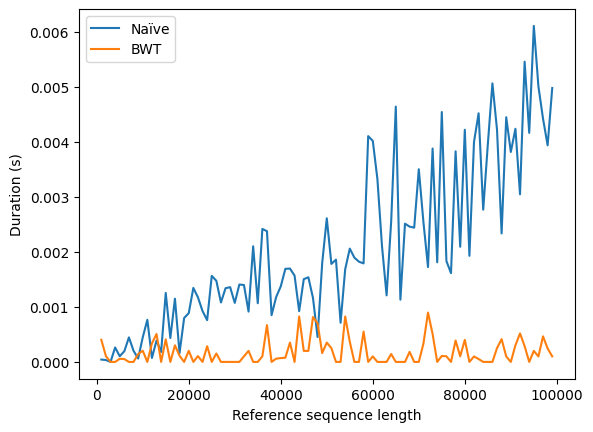

In [40]:
# Fake BWA, just for estimating time.
def fake_BWA(bwt: str, suffixes: tuple[int], read: str):
    bands = {
        "A": 0,
        "C": int(len(bwt) / 4),
        "G": int(len(bwt) / 2),
        "T": int(len(bwt) / 4 * 3)
    }

    def recurse(start, end, read, index):
        if index < 0:
            return start, end
        s = read[index]
        # Computing the ranks can be optimized by binning regions of the BWT,
        # so I simulate it here by counting the characters on short substrings.
        rank_top = len([s for s in bwt[:100] if s == "A"])
        rank_bottom = len([s for s in bwt[:100] if s == "C"])
        return recurse(bands[s], bands[s], read, index - 1)

    r = recurse(0, len(read), read, len(read) - 1)
    return suffixes[r[0]]


M, R = 10, 32


def benchmark_bwt(n: int) -> float:
    """Time BW alignment, excluding the time taken to compute the transform.

    Computing the whole BWT for long sequences is unoptimized Python is long,
    so we'll instead perform the same nombre of operations that a BW alignment
    would, but not actually use the real function.
    """
    total = 0
    for _ in range(M):
        sequence = "".join([choice(NUCLEOTIDES) for _ in range(n)])
        S = randint(0, len(sequence) - R)
        read = sequence[S:S + R]
        bwt, suffixes = sequence, list(range(len(sequence)))  # Fake data
        start = time.time()
        fake_BWA(bwt, suffixes, read)
        end = time.time()
        total += end - start
    return total / M


def benchmark_naive_alignment(n: int) -> float:
    total = 0
    for _ in range(M):
        sequence = "".join([choice(NUCLEOTIDES) for _ in range(n)])
        S = randint(0, len(sequence) - R)
        read = sequence[S:S + R]
        start = time.time()
        for i in range(len(sequence) - R):
            c = sequence[i:i + R]
            if c == read:
                break
        end = time.time()
        total += end - start
    return total / M


fig, ax = plt.subplots()
N = range(1000, 100000, 1000)
ax.plot(N, [benchmark_naive_alignment(n) for n in N], label="Naïve")
ax.plot(N, [benchmark_bwt(n) for n in N], label="BWT")
ax.set(xlabel='Reference sequence length', ylabel='Duration (s)')
plt.legend()
plt.show()

Some observations:

- Burrows-Wheeler alignment is faster for long references, but...
- Computing the BWT can take a lot of time!
- If we often align reads against **different, short references**, the naïve approach is a serious
  option on many systems because you don't have to spend time computing the BWT.
- If we often align reads against **the same, long reference** (e.g. the reference human genome),
  BW is generally much faster. Computing the BWT takes time, but we only have to do it once so it
  doesn't matter.

### Programs to use

Burrows-Wheeler transform:

- Bowtie 2 https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml
- Minimap https://github.com/lh3/minimap2
- BWA https://bio-bwa.sourceforge.net/

One problem I completely ignored here is the presence of mismatches. If often happens that reads are
not properly sequenced or that the genome of one organism differs from the reference, so reads
rarely match exactly to the reference genome. You can refer to the blog post
https://medium.com/@mr-easy/burrows-wheeler-alignment-part-2-89e08729822a to see how we can handle
mismatches with alignment based on the BWT.

<a id='part3'></a>

## 3. Genome Annotation

Annotation consists in adding notes to the assembling genome to explain how it works. Like, "this
region of the DNA is a gene that makes this protein" or "this other section promotes the expression
of some other gene". So far, we've (1) obtained reads from the genome of an organism and (2)
assembled the reads into a full genome. But it's not very useful. Even for an experienced biologist,
it remains just a bunch of letters. Annotations will provide the information required to understand
the genome. There are two main types of annotations:

- Structural annotations: identify functional elements
- Functional annotations: explain the function of the functional elements

### A Real Genome

So far, we've used simulated sequences, but that would not make sense in this section because we are
trying to annotate real elements in an actual biological function. We'll therefore use the genome of
*Escherichia coli*, a species of bacteria. The NIH hosts several genomes, you can check them out at
https://www.ncbi.nlm.nih.gov/datasets/genome/. For E. coli, I obtained data as follows:

- Visit https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000005845.2/
- Click on the `Download` button
- Select `RefSeq only`
- Check the `Genome sequences (FASTA)` and `Annotation features (GTF)` boxes
- Click on the `Download` button

The result is versioned in this repository in the `ncbi_data` so you don't have to download it
yourself if you cloned this repository.

#### Sequences

The **sequence** file located at `ncbi_dataset/ncbi_dataset/data/GCF_000005845.2/GCF_000005845.2_ASM584v2_genomic.fna`
contains the raw base pair sequence of the genome. Here are the first few lines:

```
>NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTG
GTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGAC
AGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGT
```

It's pretty straightforward.

#### Annotations

The **annotation** file located at `ncbi_dataset/ncbi_dataset/data/GCF_000005845.2/genomic.gtf`
contains a list of functional elements. Let's inspect the first few lines:

```
#gtf-version 2.2
#!genome-build ASM584v2
#!genome-build-accession NCBI_Assembly:GCF_000005845.2
NC_000913.3	RefSeq	gene	190	255	.	+	.	gene_id "b0001"; transcript_id ""; db_xref "ASAP:ABE-0000006"; db_xref "ECOCYC:EG11277"; db_xref "GeneID:944742"; gbkey "Gene"; gene "thrL"; gene_biotype "protein_coding"; gene_synonym "ECK0001"; locus_tag "b0001"; 
NC_000913.3	RefSeq	CDS	190	252	.	+	0	gene_id "b0001"; transcript_id "gnl|b0001|mrna.NP_414542"; db_xref "UniProtKB/Swiss-Prot:P0AD86"; gbkey "CDS"; gene "thrL"; locus_tag "b0001"; orig_transcript_id "gnl|b0001|mrna.NP_414542"; product "thr operon leader peptide"; protein_id "NP_414542.1"; transl_table "11"; exon_number "1"; 
NC_000913.3	RefSeq	start_codon	190	192	.	+	0	gene_id "b0001"; transcript_id "gnl|b0001|mrna.NP_414542"; db_xref "UniProtKB/Swiss-Prot:P0AD86"; gbkey "CDS"; gene "thrL"; locus_tag "b0001"; orig_transcript_id "gnl|b0001|mrna.NP_414542"; product "thr operon leader peptide"; protein_id "NP_414542.1"; transl_table "11"; exon_number "1"; 
NC_000913.3	RefSeq	stop_codon	253	255	.	+	0	gene_id "b0001"; transcript_id "gnl|b0001|mrna.NP_414542"; db_xref "UniProtKB/Swiss-Prot:P0AD86"; gbkey "CDS"; gene "thrL"; locus_tag "b0001"; orig_transcript_id "gnl|b0001|mrna.NP_414542"; product "thr operon leader peptide"; protein_id "NP_414542.1"; transl_table "11"; exon_number "1"; 
```

The first three lines identify the file itself and each subsequent line describes a functional
element with tab-separated values, as described at https://useast.ensembl.org/info/website/upload/gff.html.
For instance,

| Name of the Value   | Value                  | Description |
| ------------------- | ---------------------- | ----------- |
| Sequence name       | NC_000913.3            | Identifier |
| Source              | RefSeq                 | Algorithm or database used for this annotation |
| Feature             | gene                   | Type of feature |
| Start               | 190                    | 1-based index of the start of the feature |
| End                 | 255                    | 1-based index of the end of the feature |
| Score               | .                      | Generally indicates the confidence level. `.` means undefined. |
| Strand              | +                      | Direction of the feature. `+` means forward. |
| Frame               | .                      | Indicates where the feature starts in relation to the `start` index |
| Attribute           | `gene_id "b0001"; ...` | Additional information |

Let's try to read this gene in the reference genome. We'll only look at the
first ~500 base pairs instead of the entire genome.

In [ ]:
E_COLI_SEQUENCE_FILEPATH = "ncbi_dataset/ncbi_dataset/data/GCF_000005845.2/GCF_000005845.2_ASM584v2_genomic.fna"
E_COLI_ANNOTATION_FILEPATH = "ncbi_dataset/ncbi_dataset/data/GCF_000005845.2/genomic.gtf"


def read_reference(n: int) -> str:
    """Return the first ~n characters of the reference genome."""
    sequence = ""
    with open(E_COLI_SEQUENCE_FILEPATH, "r") as f:
        next(f)  # Skip the header :)
        for line in f:
            sequence += line[:-1]  # Skip the newline character
            if len(sequence) > n:
                break
    return sequence


def read_annotations(n: int) -> dict:
    """Return the first n annotations of the genome."""
    annotations = []
    with open(E_COLI_ANNOTATION_FILEPATH, "r") as f:
        [next(f) for _ in range(3)]  # Skip the headers :)
        for line in f:
            values = line.split("\t")
            annotations.append(
                {
                    "Name": values[0],
                    "Source": values[1],
                    "Type": values[2],
                    "Start": int(values[3]),
                    "End": int(values[4]),
                    "Score": values[5],
                    "Strand": values[6],
                    "Phase": values[7],
                    "Attributes": values[8],
                }
            )
            if len(annotations) > n:
                break
    return annotations


annotation = read_annotations(1)[0]
print(json.dumps(annotation, indent=4))
sequence = read_reference(500)
print(f"Sequence: {sequence}")
print(f"    Gene: ", end="")
print(f"{' ' * (annotation['Start'] - 1)}^^^", end="")
length = annotation['End'] - annotation['Start'] - (3 * 2) + 1  # Exclude the start and stop codons
print(f"{'>' * length}^^^")

{
    "Name": "NC_000913.3",
    "Source": "RefSeq",
    "Type": "gene",
    "Start": 190,
    "End": 255,
    "Score": ".",
    "Strand": "+",
    "Phase": ".",
    "Attributes": "gene_id \"b0001\"; transcript_id \"\"; db_xref \"ASAP:ABE-0000006\"; db_xref \"ECOCYC:EG11277\"; db_xref \"GeneID:944742\"; gbkey \"Gene\"; gene \"thrL\"; gene_biotype \"protein_coding\"; gene_synonym \"ECK0001\"; locus_tag \"b0001\"; \n"
}
Sequence: AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTT
    Gen

Genes are composed of **codons**, groups of 3 nucleotides that each correspond to a specific amino
acid. The sequence of codons is used by ribosomes to build proteins. The process goes as follows:

```
Gene ----(TRANSCRIPTION)----> Messenger RNA ----(TRANSLATION)----> Protein
```

The nucleotides marked by `^^^` in the output above indicate the start and stop codons and the ones
marked by `>>>`, to amino acids.

### 3.1 Structural Annotation

Our goal is to find functional elements in the genome. In this example, we'll identify genes, but
it's also possible to find other functional elements, like regulatory regions.

The oldest approach for structural annotation is called **ab initio**. It uses only the sequence
itself without relying on external information, which makes it simple but not very accurate. The
most basic ab initio method consists in finding open reading frames (ORF), which are the possible
ways a ribosome could read the codons. A sequence has six reading frames because codons can be
shifted by 0, 1, or 2 positions and they can be read in forward or reverse order. For instance, the
sequence

```
5' ACCGGTTAA 3'
   |||||||||
3' TGGCCAATT 5'
```

has the following ORF:

| Shift  | Direction    | Frame          | Codons        |
| ------ | ------------ | -------------- | ------------- |
| 0      | forward      | `ACCGGTTAA`    | `ACC GGT TAA` |
| 1      | forward      | `CCGGTTAA`     | `CCG GTT AA` (incomplete) |
| 2      | forward      | `CGGTTAA`      | `CGG TTA A`  (incomplete) |
| 0      | reverse      | `TTAACCGGT`    | `TTA ACC GGT` |
| 1      | reverse      | `TAACCGGT`     | `TAA CCG GT` (incomplete) |
| 2      | reverse      | `AACCGGT`      | `AAC CGG T` (incomplete) |

So we can analyze the six frames and try to find sequences that begin with a start codon and end
with a stop codon. Let's try this with the E. coli genome excerpt:

In [ ]:
START_CODONS = ("ATG", )
STOP_CODONS = ("TAA", "TAG", "TGA")


def reverse_complement(sequence: str) -> str:
    complement = []
    matches = {"A": "T", "C": "G", "G": "C", "T": "A"}
    for s in sequence[::-1]:
        complement.append(matches[s])
    return "".join(complement)


def get_frames(sequence: str) -> tuple[str]:
    orfs = []
    for shift in (0, 1, 2):
        orfs.append((sequence[shift:], shift, 1))
    complement = reverse_complement(sequence)
    for shift in (0, 1, 2):
        orfs.append((complement[shift:], shift, -1))
    return orfs


def get_codons(sequence: str) -> tuple[str]:
    codons = []
    for i in range(0, len(sequence), 3):
        codons.append(sequence[i:i + 3])
    return codons


def find_open_reading_frames(sequence: str) -> tuple[tuple[int]]:
    ORFs = []
    for frame, shift, direction in get_frames(sequence):
        is_in_ORF = False
        start = 0
        for i, codon in enumerate(get_codons(frame)):
            if codon in START_CODONS and not is_in_ORF:
                is_in_ORF = True
                start = i
            if codon in STOP_CODONS and is_in_ORF:
                is_in_ORF = False
                ORFs.append((
                    (
                        start * 3 + 1,  # Convert to 1-based indices.
                        i * 3 + 3  # Convert to 1-based indices and include the length of the codon.
                    ),
                    (shift, direction)
                ))
    return ORFs


sequence = read_reference(300)
ORFs = find_open_reading_frames(sequence)
print(f"Found {len(ORFs)} potential ORFs: {ORFs}")
for orf in ORFs:
    if orf[1][1] == 1:
        delta = orf[0][1] - orf[0][0] - orf[1][0] + 1
    else:
        delta = orf[0][1] - orf[0][0] - orf[1][0] - 1
    start = orf[0][0] + orf[1][0]
    symbol = ">" if orf[1][1] == 1 else "<"
    print(f"Sequence: {sequence}")
    print(f"         {' ' * start}{symbol * delta}")
    print()

Found 4 potential ORFs: [((190, 255), (0, 1)), ((28, 96), (2, 1)), ((91, 213), (0, -1)), ((133, 150), (1, -1))]
Sequence: AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGG
                                                                                                                                                                                                       >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Sequence: AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAG

```
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
TGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTG
GTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGG
TCACTAAATACTTTAACCAATATAGGCATAGCGCACAGAC
AGATAAAAATTACAGAGTACACAACATCCATGAAACGCAT
TAGCACCACCATTACCACCACCATCACCATTACCACAGGT
AACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAG
CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGG
```

From the annotated genome, we know that there is actually only one ORF from the bases 0 to 500. It
is the gene `b0001`, which extends from the bases 190 to 255. There is another one, `b0002`, but it
extends beyond the base 500, so it cannot be obtained by the function `find_open_reading_frames`.
You can view the genome interactively at https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.3?report=graph
to get a better idea.

So the function `find_open_reading_frames` did find the ORF for the gene `b0001`, but it also found
5 other false positives. And that's normal: a gene does not *just* need a start and stop codon, it
also need special sequences around it to enable the molecular machinery to recognize it as a gene.
For instance, in prokaryotes, the Shine-Delgarno sequence (https://en.wikipedia.org/wiki/Shine%E2%80%93Dalgarno_sequence)
helps initiate protein synthesis and in eukaryotes, the Kozak consensus sequence
(https://en.wikipedia.org/wiki/Kozak_consensus_sequence) helps start gene transcription. We can
filter the potential ORFs in multiple ways:

- Ignore potential ORFs if they are too short.
- If the organism has a well-studied codon usage pattern, we can ignore potential ORFs that use a
  lot of codons uncommon in that organism.
- Compare the potential ORFs to similar known genes
- Identify initiation sites around the genes to better recognize valid ORFs.

But no matter how many heuristics we add to the ab initio method, we might still end up with a lot
of false positives.

Another approach is **homology-based annotation**, which means that we identify functional elements
by comparing them to known sequences. For instance, if we know a gene in one bacteria, we can align
that gene to the genome of a similar bacteria to find a similar sequence, which may constitute a
gene.

A third type of approaches are **evidence-based annotations**. It works backward: we discover a
piece of protein or RNA, deduce the DNA sequence that was used to make it, and try to find this DNA
sequence in the reference genome.

### 3.2 Functional Annotation

When researchers discover the function of genes, they add entries in databases to describe them.
For example, if you visit the interactive genome viewer of the NCBI (https://www.ncbi.nlm.nih.gov/gdv/browser/genome/?id=GCF_000001405.40)
and search "ABO" in the "Search assembly" box, you'll find a gene that participates in determining
blood groups in humans. Click on the "detail" link to land on a page that provides functional
annotations for this gene along with homologous sequences and links to research papers.